In [1]:
import h5py
import torch
import numpy as np
import random
from IPython import display
from matplotlib import pyplot as plt
import torch.utils.data as Data
from PIL import Image
import os
from torch import nn
import torch.optim as optim
from torch.nn import init
import torch.nn.functional as F
import time
import pandas as pd
from sklearn.utils import shuffle
import math
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
#plt.switch_backend('agg')

In [2]:
f_data = h5py.File("./BikeNYC/NYC14_M16x8_T60_NewEnd.h5")
BikeNYC_date = f_data['date']
BikeNYC_data = f_data['data']
print(f'date: \n{BikeNYC_date[0]}\n shape:{BikeNYC_date.shape} \n in_flow:\n{BikeNYC_data[0][0]} \n out_flow: \n{BikeNYC_data[0][1]}')
print(BikeNYC_data.shape)

date: 
b'2014040101'
 shape:(4392,) 
 in_flow:
[[0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 4. 1. 1. 0. 0.]
 [0. 0. 2. 5. 0. 2. 2. 0.]
 [0. 0. 2. 0. 0. 0. 0. 0.]
 [0. 1. 3. 1. 4. 2. 0. 0.]
 [0. 3. 3. 6. 3. 0. 0. 0.]
 [0. 2. 6. 5. 5. 0. 0. 0.]
 [0. 6. 3. 8. 1. 0. 0. 0.]
 [0. 2. 0. 2. 0. 0. 0. 0.]
 [3. 4. 5. 0. 1. 0. 1. 0.]
 [0. 2. 2. 1. 0. 0. 2. 1.]
 [1. 1. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 3. 1. 0.]
 [0. 0. 0. 1. 2. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 1.]] 
 out_flow: 
[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 3. 2. 1. 0. 0.]
 [0. 0. 0. 3. 0. 1. 0. 0.]
 [0. 1. 1. 2. 1. 0. 0. 0.]
 [0. 4. 2. 1. 2. 0. 0. 0.]
 [0. 1. 5. 5. 3. 0. 0. 0.]
 [0. 2. 5. 3. 4. 0. 0. 0.]
 [0. 2. 4. 7. 0. 0. 0. 0.]
 [1. 1. 2. 9. 1. 0. 0. 0.]
 [1. 1. 2. 2. 1. 0. 2. 0.]
 [1. 2. 2. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 2. 1. 0. 1. 0.]
 [0. 0. 0. 0. 1. 2. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]]
(4392, 2, 16, 8)


In [3]:
BikeNYC_data_square = np.concatenate((BikeNYC_data[:,0,:,:],BikeNYC_data[:,1,:,:]),axis=2)
print(BikeNYC_data_square.shape)
print(BikeNYC_data_square[0,:,:])

(4392, 16, 16)
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 4. 1. 1. 0. 0. 0. 0. 0. 3. 2. 1. 0. 0.]
 [0. 0. 2. 5. 0. 2. 2. 0. 0. 0. 0. 3. 0. 1. 0. 0.]
 [0. 0. 2. 0. 0. 0. 0. 0. 0. 1. 1. 2. 1. 0. 0. 0.]
 [0. 1. 3. 1. 4. 2. 0. 0. 0. 4. 2. 1. 2. 0. 0. 0.]
 [0. 3. 3. 6. 3. 0. 0. 0. 0. 1. 5. 5. 3. 0. 0. 0.]
 [0. 2. 6. 5. 5. 0. 0. 0. 0. 2. 5. 3. 4. 0. 0. 0.]
 [0. 6. 3. 8. 1. 0. 0. 0. 0. 2. 4. 7. 0. 0. 0. 0.]
 [0. 2. 0. 2. 0. 0. 0. 0. 1. 1. 2. 9. 1. 0. 0. 0.]
 [3. 4. 5. 0. 1. 0. 1. 0. 1. 1. 2. 2. 1. 0. 2. 0.]
 [0. 2. 2. 1. 0. 0. 2. 1. 1. 2. 2. 0. 0. 0. 0. 1.]
 [1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 3. 1. 0. 0. 0. 0. 2. 1. 0. 1. 0.]
 [0. 0. 0. 1. 2. 0. 0. 0. 0. 0. 0. 0. 1. 2. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.]]


In [4]:
#读取数据集，进行划分
def sliding_window(seq,window_size):
    result = []
    for i in range(seq.shape[0]- window_size):
        result.append(seq[i: i+window_size])
    result = np.array(result)
    return result

def MLPreshape(set):
    set = set.reshape((set.shape[0],set.shape[1],-1))
    return set

def MLPreshape_inverse(set):
    set = set.reshape((set.shape[0],set.shape[1],16,16))
    return set

data_num = BikeNYC_date.shape[0]
# flow_in_num = 0
train_seq = BikeNYC_data_square[:int(data_num*0.7),:,:]
validation_seq = BikeNYC_data_square[int(data_num*0.7):int(data_num*0.8),:,:]
test_seq = BikeNYC_data_square[int(data_num*0.8):,:,:]
print(train_seq.shape,validation_seq.shape,test_seq.shape)

window_size = 7
train_set = sliding_window(train_seq, window_size)
validation_set = sliding_window(validation_seq, window_size)
test_set = sliding_window(test_seq, window_size)
print(train_set.shape)
print(validation_set.shape)
print(test_set.shape)

train_set = MLPreshape(train_set)
validation_set = MLPreshape(validation_set)
test_set = MLPreshape(test_set)

print(train_set.shape)
print(validation_set.shape)
print(test_set.shape)

(3074, 16, 16) (439, 16, 16) (879, 16, 16)
(3067, 7, 16, 16)
(432, 7, 16, 16)
(872, 7, 16, 16)
(3067, 7, 256)
(432, 7, 256)
(872, 7, 256)


In [39]:
dropout_parameter = 0.01
class OutputNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim1, hidden_dim2, action_dim):
        super(OutputNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim1)
        self.fc2 = torch.nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = torch.nn.Linear(hidden_dim2, action_dim)
        self.fc4 = torch.nn.Dropout(dropout_parameter)
        self.fc5 = torch.nn.Dropout(dropout_parameter)
        self.fc6 = torch.nn.Dropout(dropout_parameter)

    def forward(self, x):
        x = F.leaky_relu_(self.fc1(x))
        # x = self.fc4(x)
        x = F.leaky_relu_(self.fc2(x))
        # x = self.fc5(x)
        x = F.leaky_relu_(self.fc3(x))
        return self.fc6(x)


In [6]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = (y_true > 0)
    y_true = y_true[non_zero_index]
    y_pred = y_pred[non_zero_index]

    mape = np.abs((y_true - y_pred) / y_true)
    mape[np.isinf(mape)] = 0
    return np.mean(mape) * 100

In [7]:
def next_batch(data, batch_size):
    data_length = data.shape[0]
    num_batches = math.ceil(data_length / batch_size)
    for batch_index in range(num_batches):
        start_index = batch_index * batch_size
        end_index = min((batch_index + 1) * batch_size, data_length)
        yield data[start_index:end_index]

In [33]:
class ConvolutionNet(torch.nn.Module):
    def __init__(self):
        super(ConvolutionNet, self).__init__()
        self.block1 = nn.Sequential(
                                    nn.Conv2d(6, 64, kernel_size=4, stride=2),
                                    nn.LeakyReLU(0.02),
                                    # nn.Dropout(dropout_parameter),
                                    nn.BatchNorm2d(64),

                                    nn.Conv2d(64,128,kernel_size=3, stride=2),
                                    nn.LeakyReLU(0.02),
                                    # nn.Dropout(dropout_parameter),
                                    nn.BatchNorm2d(128),

                                    nn.Conv2d(128,120,kernel_size=3, stride=1),
                                    nn.LeakyReLU(0.02),
                                    #
                                    nn.BatchNorm2d(120),
                                    # nn.Dropout(dropout_parameter)
        )


    def forward(self, x):
        x = self.block1(x.view((x.shape[0],6,16,16)))
        # print(x.shape)
        x = x.squeeze()
        return x

In [40]:
#初始化模型
device = 'cpu'
Convolution_Net = ConvolutionNet()
torch_lstm = nn.LSTM(input_size=20, hidden_size=32, num_layers=1, batch_first=True)
output_model = OutputNet(state_dim=32, hidden_dim1=64, hidden_dim2=128, action_dim=16*16)

In [41]:
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(list(torch_lstm.parameters()) + list(output_model.parameters()) + list(Convolution_Net.parameters()), lr=0.0001)

In [43]:
#保存打印文件
f = open("./date/Dropout.txt", 'a+')

In [42]:
# 这两句只在第二次运行这个框架时运行，是为了重载文件流防止内存溢出。
f.close()
os.remove("./date/Dropout.txt")

In [44]:
train_log = []
test_log = []
#开始时间
timestart = time.time()
trained_batches = 0 #记录多少个batch
batch_size = 128
for epoch in range(500):

    total_1oss = 0 #记录Loss
    for batch in next_batch(shuffle(train_set), batch_size=batch_size):
        #每一个batch的开始时间
        batchstart = time.time()

        batch = torch.from_numpy(batch).float().to(device)  # (batch, seq_len)
        # 使用短序列的前12个值作为历史，最后一个值作为预测值。
        x, label = batch[:, :6,:], batch[:, -1,:]
        # print(x.shape)
        x = Convolution_Net(x)
        # print("Con:",x.shape)
        out, hidden = torch_lstm(x.view((x.shape[0], 6, -1)))  # out: (batch_size, seq_len, hidden_size)
        # print("out:",out.shape)
        out = output_model(out[:, -1, :])
        prediction = out  # (batch)
        # print(prediction.shape,label.shape)
        loss = loss_func(prediction, label)
#         print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        trained_batches += 1
        train_log.append(loss.detach().cpu().numpy().tolist())

        train_batch_time = (time.time() - batchstart)

        # 每训练一定数量的batch，就在测试集上测试模型效果。
        if trained_batches % 100 == 0:
            print('batch %d, train_loss %.6f,Time used %.6fs'%(trained_batches, loss,train_batch_time))
            print('batch %d, train_loss %.6f,Time used %.6fs'%(trained_batches, loss,train_batch_time),file=f)
            #每一个batch的开始时间
            batch_test_start = time.time()
            #在每个epoch上测试
            all_prediction = []
            for batch in next_batch(test_set, batch_size=128):
                batch = torch.from_numpy(batch).float().to(device)  # (batch, seq_len)
                x, label = batch[:, :6,:], batch[:, -1,:]
                x = Convolution_Net(x)
                out, hidden = torch_lstm(x.view((x.shape[0], 6, -1)))  # out: (batch_size, seq_len, hidden_size)
                out = output_model(out[:, -1, :])
                prediction = out  # (batch)
                all_prediction.append(prediction.detach().cpu().numpy())

            all_prediction = np.concatenate(all_prediction)
            all_label = test_set[:, -1]
            # 没有进行反归一化操作。
            #all_prediction = denormalize(all_prediction)
            #all_label = denormalize(all_label)
            # 计算测试指标。
            rmse_score = math.sqrt(mse(all_label, all_prediction))
            mae_score = mae(all_label, all_prediction)
            mape_score = mape(all_label, all_prediction)
            test_log.append([rmse_score, mae_score, mape_score])
            test_batch_time = (time.time() - batch_test_start)
            print('***************************test_batch %d, test_rmse_loss %.6f,test_mae_loss %.6f,test_mape_loss %.6f,Time used %.6fs'%(trained_batches, rmse_score,mae_score,mape_score,test_batch_time))
            print('***************************test_batch %d, test_rmse_loss %.6f,test_mae_loss %.6f,test_mape_loss %.6f,Time used %.6fs'%(trained_batches, rmse_score,mae_score,mape_score,test_batch_time),file=f)

#计算总时间
timesum = (time.time() - timestart)
print('The total time is %fs'%(timesum))
print('The total time is %fs'%(timesum),file=f)
f.close()

batch 100, train_loss 407.199554,Time used 0.031000s
***************************test_batch 100, test_rmse_loss 22.217999,test_mae_loss 10.139759,test_mape_loss 95.292348,Time used 0.090002s
batch 200, train_loss 361.892578,Time used 0.028001s
***************************test_batch 200, test_rmse_loss 20.018220,test_mae_loss 8.523840,test_mape_loss 77.659149,Time used 0.109997s
batch 300, train_loss 128.166580,Time used 0.025006s
***************************test_batch 300, test_rmse_loss 14.474458,test_mae_loss 5.631613,test_mape_loss 74.846934,Time used 0.083992s
batch 400, train_loss 80.575790,Time used 0.028003s
***************************test_batch 400, test_rmse_loss 10.999760,test_mae_loss 4.337501,test_mape_loss 61.376402,Time used 0.086998s
batch 500, train_loss 58.115009,Time used 0.036000s
***************************test_batch 500, test_rmse_loss 9.581498,test_mae_loss 3.895215,test_mape_loss 59.710027,Time used 0.114999s
batch 600, train_loss 63.531376,Time used 0.034000s
*****

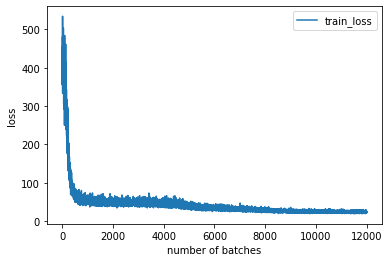

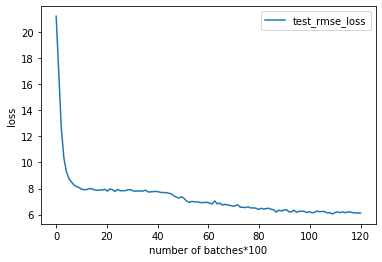

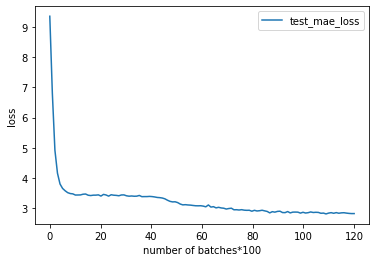

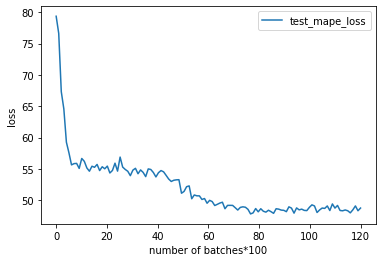

In [165]:
#train_loss曲线
x = np.linspace(0,len(train_log),len(train_log))
plt.plot(x,train_log,label="train_loss",linewidth=1.5)
plt.xlabel("number of batches")
plt.ylabel("loss")
plt.legend()
plt.savefig('./figure/1.4torchLSTMtrainloss1_RNN.jpg')
plt.show()
#plt.clf()
#test_loss曲线
x_test= np.linspace(0,len(test_log),len(test_log))
test_log = np.array(test_log)
plt.plot(x_test,test_log[:,0],label="test_rmse_loss",linewidth=1.5)
plt.xlabel("number of batches*100")
plt.ylabel("loss")
plt.legend()
plt.savefig('./figure/1.4torchLSTMtestrmseloss1_RNN.jpg')
plt.show()
#plt.clf()

#test_loss曲线
x_test= np.linspace(0,len(test_log),len(test_log))
test_log = np.array(test_log)
plt.plot(x_test,test_log[:,1],label="test_mae_loss",linewidth=1.5)
plt.xlabel("number of batches*100")
plt.ylabel("loss")
plt.legend()
plt.savefig('./figure/1.4torchLSTMtestrmaeloss1_RNN.jpg')
plt.show()
#plt.clf()

#test_loss曲线
x_test= np.linspace(0,len(test_log),len(test_log))
test_log = np.array(test_log)
plt.plot(x_test,test_log[:,2],label="test_mape_loss",linewidth=1.5)
plt.xlabel("number of batches*100")
plt.ylabel("loss")
plt.legend()
plt.savefig('./figure/1.4torchLSTMtestrmapeloss1_RNN.jpg')
plt.show()

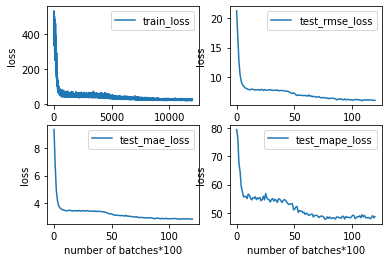

In [166]:
#train_loss曲线
x = np.linspace(0,len(train_log),len(train_log))
plt.subplot(2, 2, 1)
plt.plot(x,train_log,label="train_loss",linewidth=1.5)
plt.xlabel("number of batches")
plt.ylabel("loss")
plt.legend()

#test_loss曲线
x_test= np.linspace(0,len(test_log),len(test_log))
test_log = np.array(test_log)
plt.subplot(2, 2, 2)
plt.plot(x_test,test_log[:,0],label="test_rmse_loss",linewidth=1.5)
plt.xlabel("number of batches*100")
plt.ylabel("loss")
plt.legend()

#test_loss曲线
x_test= np.linspace(0,len(test_log),len(test_log))
test_log = np.array(test_log)
plt.subplot(2, 2, 3)
plt.plot(x_test,test_log[:,1],label="test_mae_loss",linewidth=1.5)
plt.xlabel("number of batches*100")
plt.ylabel("loss")
plt.legend()

#test_loss曲线
x_test= np.linspace(0,len(test_log),len(test_log))
test_log = np.array(test_log)
plt.subplot(2, 2, 4)
plt.plot(x_test,test_log[:,2],label="test_mape_loss",linewidth=1.5)
plt.xlabel("number of batches*100")
plt.ylabel("loss")
plt.legend()
plt.savefig('./figure/LSTM-4-photo.jpg_RNN.jpg')
plt.show()
#plt.clf()